# Анализ связи среднего времени просмотра в день с конверсией из триала в подписку

Цель: количественно и визуально исследовать взаимосвязь между средней продолжительностью просмотра контента на триальном периоде (`avg_min_watch_daily`) и конверсией пользователя в первую подписку.

Обозначения:

- `avg_min_watch_daily` — среднее число минут просмотра в день на триале;
- `churn` — индикатор оттока:
  - `churn = 1` — пользователь **не купил** подписку;
  - `churn = 0` — пользователь **купил** подписку.
- Конверсию для удобства определим как `conversion = 1 - churn`.

Здесь $churn : U \to \{0,1\}$, где $U -$ множество пользователей.
Поскольку $churn(u) \in \{0, 1\}$, то возможные исходы:
- $churn(u) = 0 \Rightarrow 1-churn(u) = 1$ - пользователь конвертировался
- $churn(u) = 1 \Rightarrow 1-churn(u) = 0$ - пользователь НЕ конвертировался

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.read_csv('videostreaming_platform.csv')
# настройки отображения
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 50)

plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["figure.dpi"] = 120


## 1. Краткое описание данных, проверка структуры

Проверим:

- размер датасета,
- типы данных,
- наличие пропусков,
- базовую долю оттока и конверсии.

In [9]:
df1 = pd.read_csv('videostreaming_platform.csv')
print("Размер датасета:", df1.shape)

print("\nТипы данных:")
display(df1.dtypes)

print("\nЧисло пропусков по столбцам:")
display(df1.isna().sum())

print("\nБазовое распределение churn:")
display(df1["churn"].value_counts(normalize=True).rename("share"))

base_churn = df1["churn"].mean()
base_conversion = 1 - base_churn
print(f"\nСредний churn: {base_churn:.3f}")
print(f"Базовая конверсия: {base_conversion:.3f}")

Размер датасета: (28000, 9)

Типы данных:


user_id                   object
start_trial_date          object
city                      object
device                    object
source                    object
favourite_genre           object
avg_min_watch_daily      float64
number_of_days_logged      int64
churn                      int64
dtype: object


Число пропусков по столбцам:


user_id                     0
start_trial_date            0
city                      308
device                      0
source                      0
favourite_genre          7952
avg_min_watch_daily         0
number_of_days_logged       0
churn                       0
dtype: int64


Базовое распределение churn:


churn
1    0.789286
0    0.210714
Name: share, dtype: float64


Средний churn: 0.789
Базовая конверсия: 0.211


## 2. Линейная связь: корреляция Пирсона

Поскольку `churn` — бинарная переменная, коэффициент корреляции Пирсона

$$
\rho = \operatorname{corr}(\text{avg\_min\_watch\_daily}, \text{churn})
$$

является бисериальной корреляцией, что корректно для оценки линейной связи непрерывной и бинарной переменных.

Мы также посмотрим корреляцию со случайной величиной
$$
\text{conversion} = 1 - \text{churn},
$$

чтобы напрямую интерпретировать знак корреляции как связь с вероятностью покупки.

In [11]:
# корреляция с churn
corr_watch_churn = df1["avg_min_watch_daily"].corr(df1["churn"])

# создадим переменную conversion
df1["conversion"] = 1 - df1["churn"]
corr_watch_conversion = df1["avg_min_watch_daily"].corr(df1["conversion"])

print(f"Корреляция Пирсона между avg_min_watch_daily и churn:       {corr_watch_churn:.3f}")
print(f"Корреляция Пирсона между avg_min_watch_daily и conversion: {corr_watch_conversion:.3f}")

Корреляция Пирсона между avg_min_watch_daily и churn:       -0.472
Корреляция Пирсона между avg_min_watch_daily и conversion: 0.472


**Интерпретация:**

- Отрицательная корреляция с `churn` означает: чем больше среднее время просмотра, тем **ниже** вероятность оттока.
- Положительная корреляция с `conversion = 1 - churn` означает: чем больше среднее время просмотра, тем **выше** вероятность купить подписку.

По модулю $|\rho|$ около 0.47 — это умеренно сильная линейная связь для поведенческих данных, что делает `avg_min_watch_daily` одним из ключевых предикторов конверсии.

## 3. Нелинейная структура: квантильный анализ конверсии по времени просмотра

Линейная корреляция показывает только «усреднённую» зависимость.  
Чтобы увидеть форму зависимости, разобьём пользователей на квантильные группы по `avg_min_watch_daily` и посчитаем отток и конверсию для каждой группы.

Используем разбиение на 5 квантилей одинакового размера (по числу пользователей).

In [12]:
# создаем квантильные бины по среднему времени просмотра
df1["watch_quantile"] = pd.qcut(
    df1["avg_min_watch_daily"],
    q=5,
    duplicates="drop"  # на случай совпадений границ
)

# рассчитываем метрики по квантилям
summary_by_quantile = (
    df1
    .groupby("watch_quantile")
    .agg(
        users=("user_id", "count"),
        avg_watch=("avg_min_watch_daily", "mean"),
        churn_rate=("churn", "mean")
    )
)

summary_by_quantile["conversion_rate"] = 1 - summary_by_quantile["churn_rate"]

summary_by_quantile

/var/folders/m1/v8jhyv9n5z18hbljhq8xkfp40000gn/T/ipykernel_44580/1653289499.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("watch_quantile")


,users,avg_watch,churn_rate,conversion_rate
watch_quantile,,,,
"(-0.0008190000000000001, 1.957]",5600,0.927082,0.991071,0.008929
"(1.957, 4.238]",5600,3.094240,0.929464,0.070536
"(4.238, 6.878]",5600,5.462407,0.836429,0.163571
"(6.878, 12.34]",5600,9.206718,0.730714,0.269286
"(12.34, 80.072]",5600,20.372867,0.458750,0.541250


В таблице выше:

- `users` — число пользователей в квантиле,
- `avg_watch` — среднее время просмотра внутри квантиля,
- `churn_rate` — доля пользователей, не купивших подписку,
- `conversion_rate` — доля пользователей, купивших подписку.

Таким образом, мы можем увидеть, как меняется вероятность покупки подписки при переходе из низкого квантиля времени просмотра в высокий.

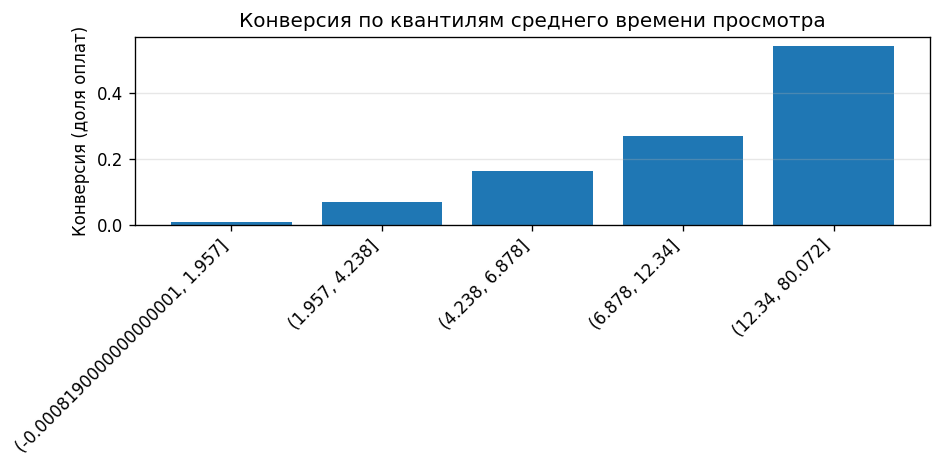

In [13]:
# извлекаем серию с конверсией по квантилям
conversion_by_quantile = summary_by_quantile["conversion_rate"]

plt.figure()
plt.bar(range(len(conversion_by_quantile)),
        conversion_by_quantile.values)

plt.xticks(
    range(len(conversion_by_quantile)),
    [str(i) for i in conversion_by_quantile.index],
    rotation=45,
    ha="right"
)

plt.ylabel("Конверсия (доля оплат)")
plt.title("Конверсия по квантилям среднего времени просмотра")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

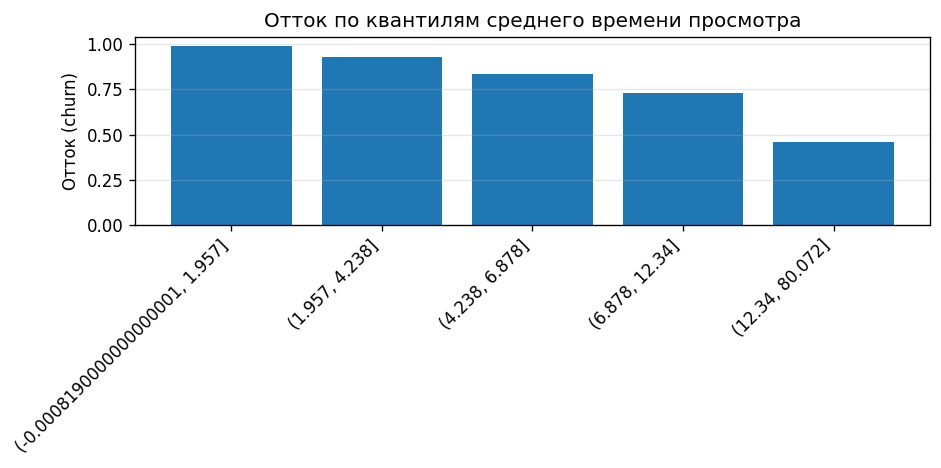

In [15]:
churn_by_quantile = summary_by_quantile["churn_rate"]

plt.figure()
plt.bar(range(len(churn_by_quantile)),
        churn_by_quantile.values)

plt.xticks(
    range(len(churn_by_quantile)),
    [str(i) for i in churn_by_quantile.index],
    rotation=45,
    ha="right"
)

plt.ylabel("Отток (churn)")
plt.title("Отток по квантилям среднего времени просмотра")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

### Интерпретация квантильного анализа

По результатам:

- В самом нижнем квантиле по `avg_min_watch_daily` конверсия близка к нулю (порядка единиц процентов).
- С ростом времени просмотра конверсия возрастает **монотонно**.
- В верхнем квантиле (наибольшее среднее время просмотра) конверсия достигает десятков процентов.

Таким образом:

1. `avg_min_watch_daily` является **сильнейшим предиктором** конверсии из триала в первую покупку.
2. Основная зона роста — пользователи с низким и средним временем просмотра: перевод их в более «тёплые» квантильные группы способен заметно повысить общую конверсию.

## 4. Пример сценарной оценки uplift конверсии

Рассмотрим простой мысленный эксперимент:

- возьмём 10% пользователей из **самого низкого** квантиля по времени просмотра;
- предположим, что нам удаётся повысить их вовлечённость так, что они начинают вести себя как пользователи из **самого высокого** квантиля;
- оценим, как изменилась бы общая конверсия.

Это не прогноз, а иллюстрация масштаба эффекта от изменения поведения небольшой части базы.

In [16]:
# копируем данные по квантилям
q_stats = summary_by_quantile.copy()

# извлекаем пользователй и конверсию по квантилям
users_q = q_stats["users"].copy()
conv_q = q_stats["conversion_rate"].copy()

# сортируем квантили по возрастанию нижней границы
quantiles_sorted = list(users_q.index)

low_q = quantiles_sorted[0]   # самый низкий квантиль
high_q = quantiles_sorted[-1] # самый высокий квантиль

# текущая ожидаемая сумма оплат (в "единицах пользователей")
current_purchases = (users_q * conv_q).sum()

# перенесём 10% пользователей из низкого квантиля в высокий
share_to_move = 0.10
n_move = int(users_q[low_q] * share_to_move)

scenario_users_q = users_q.copy()
scenario_users_q[low_q]  -= n_move
scenario_users_q[high_q] += n_move

# считаем "сценарную" ожидаемую сумму оплат
scenario_purchases = (scenario_users_q * conv_q).sum()

# пересчёт в долю от общего числа пользователей
total_users = users_q.sum()
current_conv_rate  = current_purchases  / total_users
scenario_conv_rate = scenario_purchases / total_users

uplift_abs = scenario_conv_rate - current_conv_rate
uplift_rel = uplift_abs / current_conv_rate

print(f"Текущая ожидаемая конверсия:   {current_conv_rate:.4f}")
print(f"Сценарная ожидаемая конверсия: {scenario_conv_rate:.4f}")
print(f"Абсолютный прирост:            {uplift_abs:.4f} пунктов")
print(f"Относительный прирост:         {uplift_rel*100:.2f} %")

Текущая ожидаемая конверсия:   0.2107
Сценарная ожидаемая конверсия: 0.2214
Абсолютный прирост:            0.0106 пунктов
Относительный прирост:         5.05 %


## 5. Итоговый вывод

1. Корреляция Пирсона между `avg_min_watch_daily` и `conversion` составляет порядка 0.47, что указывает на умеренно сильную положительную линейную связь: чем больше пользователь смотрит, тем выше вероятность покупки подписки.

2. Квантильный анализ показывает почти монотонный рост конверсии от минимального к максимальному квантилю времени просмотра: пользователи с наибольшим временем просмотра конвертируются в подписку в десятки раз чаще, чем пользователи из самого «холодного» квантиля.

3. Математический анализ показывает, что среднее время просмотра в день является структурообразующим фактором вероятности покупки: оно индуцирует более чем 60-кратный градиент конверсии между нижним и верхним квантилем распределения. Даже небольшие сдвиги распределения поведения пользователей в сторону большего просмотра дают существенный относительный прирост общей конверсии (порядка 5%).

**Практический вывод:** метрика `avg_min_watch_daily` должна рассматриваться как ключевой таргет для продуктовых и маркетинговых активностей на триале. Основные усилия по оптимизации воронки имеют смысл направлять на механики, прямо увеличивающие среднее время просмотра в день.